# Импортирование библиотек

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import numpy as np
import numpy.ma as ma

from scipy import stats as st
from scipy.stats.mstats import gmean, hmean
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import geopandas as gpd
import fiona
from fiona.drvsupport import supported_drivers
from shapely.geometry import Polygon
from shapely.ops import unary_union

from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pylab as plt

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Загрузка реальных данных о пастбище в формате .jp2
## дата: 2022/06/24

In [2]:
S_sentinel_bands = glob("./Pasture_Images/dates/20220624/*B?*.tif")
S_sentinel_bands.sort()
S_sentinel_bands

['./Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R10B02.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R10B03.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R10B04.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R10B08.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B05.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B06.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B07.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B11.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B12.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R20B8A.TIF',
 './Pasture_Images/dates/20220624\\S2A_tile_20220624_42UWF_0_R60B09.TIF']

# Формирование стэка (3-х мерной матрицы) изображении

In [3]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

In [4]:
print(len(l[0]), "пикселей || # Канал B01. Разрешение 60m") # Канал B01. Разрешеие (60 m)
print(len(l[8]), "пикселей || # Канал B09. Разрешение 60m") # Канал B09. Разрешеие (20 m) -> (60 m)
print(len(l[9]), "пикселей || # Канал B10. Разрешение 60m") # Канал B10. Разрешеие (60 m)
print()
print(len(l[4]), "пикселей || # Канал B05. Разрешение 20m") # Канал B05. Разрешеие (20 m)
print(len(l[5]), "пикселей || # Канал B06. Разрешение 20m") # Канал B06. Разрешеие (20 m)
print(len(l[6]), "пикселей || # Канал B07. Разрешение 20m") # Канал B07. Разрешеие (20 m)
print(len(l[10]), "пикселей || # Канал B11. Разрешение 20m") # Канал B11. Разрешеие (60 m)  -> (20 m)
print(len(l[11]), "пикселей || # Канал B12. Разрешение 20m") # Канал B12. Разрешеие (20 m)
print(len(l[12]), "пикселей || # Канал B8A. Разрешение 20m") # Канал B8A. Разрешеие (20 m)
print()
print(len(l[1]), "пикселей || # Канал B02. Разрешение 10m") # Канал B02. Разрешеие (10 m)
print(len(l[2]), "пикселей || # Канал B03. Разрешение 10m") # Канал B03. Разрешеие (10 m)
print(len(l[3]), "пикселей || # Канал B04. Разрешение 10m") # Канал B04. Разрешеие (10 m)
print(len(l[7]), "пикселей || # Канал B08. Разрешение 10m") # Канал B08. Разрешеие (10 m)


1830 пикселей || # Канал B01. Разрешение 60m
1830 пикселей || # Канал B09. Разрешение 60m
1830 пикселей || # Канал B10. Разрешение 60m

5490 пикселей || # Канал B05. Разрешение 20m
5490 пикселей || # Канал B06. Разрешение 20m
5490 пикселей || # Канал B07. Разрешение 20m
5490 пикселей || # Канал B11. Разрешение 20m
5490 пикселей || # Канал B12. Разрешение 20m
5490 пикселей || # Канал B8A. Разрешение 20m

10980 пикселей || # Канал B02. Разрешение 10m
10980 пикселей || # Канал B03. Разрешение 10m
10980 пикселей || # Канал B04. Разрешение 10m
10980 пикселей || # Канал B08. Разрешение 10m


In [4]:
# arr60_st = np.stack([l[0],l[8],l[9]])
# arr20_st = np.stack([l[4],l[5],l[6],l[10],l[11],l[12]])
# arr10_st = np.stack([l[1],l[2],l[3],l[7]])
arr10_st = np.stack([l[0],l[1],l[2],l[3]])

orig_image_width, orig_image_height = arr10_st.shape[1], arr10_st.shape[2]

# Обрезка изображении по GPS координатам

In [5]:
supported_drivers['KML'] = 'rw'

pasture_df = gpd.read_file('pasture.kml', driver='KML')
global_df = gpd.read_file('global.kml', driver='KML')

# geo_df = gpd.read_file('grid.geojson')
# new_42UWF = geo_df[geo_df["name"] == "42UWF"].reset_index(0, True).iloc[0]

# new_global_df = gpd.read_file('.\Sentinel-2-Shapefile-Index-master\sentinel_2_index_shapefile.shp', driver='SHP')
# another_new_42UWF = new_global_df[new_global_df["Name"] == "42UWF"].reset_index(0, True).iloc[0]

T42UWF = global_df[global_df["Name"] == "42UWF"].reset_index(0, True)
T42UWF = T42UWF.iloc[0]

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2827223230.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  new_42UWF = geo_df[geo_df["name"] == "42UWF"].reset_index(0, True).iloc[0]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2827223230.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  another_new_42UWF = new_global_df[new_global_df["Name"] == "42UWF"].reset_index(0, True).iloc[0]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2827223230.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  T42UWF = global_df[global_df["Name"] == "42UWF"].reset_index(0, True)


In [6]:
pasture_df

,Name,Description,geometry
0,Загон №1,"1832,547989 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.51202 54.21228 0.00000, 69.5119..."
1,Загон №2,"1858,037915 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.51842 54.21551 0.00000, 69.5152..."
2,Загон №3,"1908,388474 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.52507 54.21582 0.00000, 69.5196..."
3,Загон №4,"2680,592169 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.53198 54.21582 0.00000, 69.5250..."
4,Загон №5,"2847,760223 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.53210 54.21443 0.00000, 69.5319..."
5,Загон №6,"2766,483655 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.53222 54.21314 0.00000, 69.5321..."
6,Загон №7,"2781,949731 <br> <br> SHAPE_Leng ...","POLYGON Z ((69.53222 54.21314 0.00000, 69.5124..."
7,Площадка,"214,291477 <br> <br> SHAPE_Leng 2...","POLYGON Z ((69.51272 54.21209 0.00000, 69.5120..."


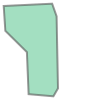

In [7]:
pasture_df.loc[0].geometry

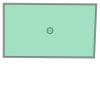

In [8]:
T42UWF.geometry

In [9]:
T42UWF.geometry.bounds

(68.9996869804, 54.0485147058, 70.7177342268, 55.0469860315)

In [10]:
for coords in pasture_df.loc[0].geometry.exterior.coords:
    print(coords)

(69.512015, 54.21227699999999, 0.0)
(69.511914, 54.217479, 0.0)
(69.511593, 54.21838700000001, 0.0)
(69.508097, 54.218222, 0.0)
(69.508215, 54.216429, 0.0)
(69.509771, 54.21489199999999, 0.0)
(69.509895, 54.211858, 0.0)
(69.511682, 54.211704, 0.0)
(69.512015, 54.21227699999999, 0.0)


In [11]:
all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)

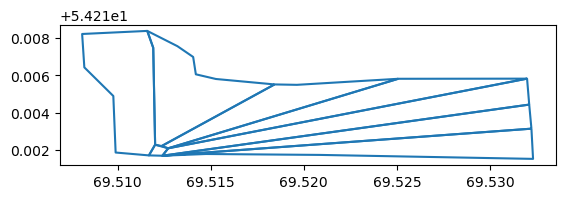

In [12]:
gpd.GeoSeries(all_zagons).boundary.plot()
plt.show()

In [13]:
merged_zagons = unary_union(all_zagons)

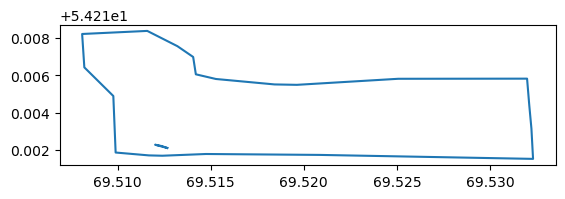

In [14]:
gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [58]:
x_min, y_min, x_max, y_max = merged_zagons.bounds 
X_min, Y_min, X_max, Y_max = T42UWF.geometry.bounds

a, b = x_max - x_min, y_max - y_min
A, B = X_max - X_min, Y_max - Y_min

print(x_min, y_min, x_max, y_max)
print(X_min, Y_min, X_max, Y_max)

print(a, b)
print(A, B)

69.508097 54.211517 69.532304 54.21838700000001
68.9996869804 54.0485147058 70.7177342268 55.0469860315
0.024206999999989876 0.006870000000006371
1.7180472464000047 0.9984713256999953


In [59]:
width_pix_ratio = A/orig_image_width
height_pix_ratio = B/orig_image_height

print("Шаг одного пикселя по Долготе(Х) в координатном выражении: ", A/orig_image_width)
print("Шаг одного пикселя по Ширине(У) в координатном выражении: ", B/orig_image_height)

Шаг одного пикселя по Долготе(Х) в координатном выражении:  0.00015278321444197463
Шаг одного пикселя по Ширине(У) в координатном выражении:  8.87687878467279e-05


In [60]:
b/a, B/A

(0.28380220597386063, 0.5811663956228164)

In [61]:
print(a/width_pix_ratio, b/height_pix_ratio)

158.44018001848906 77.39206726432286


# Квадраты на экваторе квадатные!

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2603888890.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  T33NWB = global_df[global_df["Name"] == "33NWB"].reset_index(0, True)


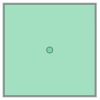

In [19]:
T33NWB = global_df[global_df["Name"] == "33NWB"].reset_index(0, True)
T33NWB = T33NWB.loc[0]
T33NWB.geometry

In [62]:
X_min, Y_min, X_max, Y_max = T42UWF.geometry.bounds
# X_min, Y_min, X_max, Y_max = another_new_42UWF.geometry.bounds
x_min, y_min, x_max, y_max = merged_zagons.bounds 

In [63]:
import pyproj

# To test out: 4326(WGS84), 3857(Google maps), 32642(Google Earth/Sentinel Tiles), 7789(ITRS)
# Kazakhstan's code = 2939

# [32642  -> 2939] = y:+69; x:+98
# [4326  -> 32642] = y:+0; x:+85

proj_wgs84 = pyproj.Proj(init="epsg:32642")
proj_kz = pyproj.Proj(init="epsg:2939")

X_min, Y_min = pyproj.transform(proj_wgs84, proj_kz, X_min, Y_min)
X_max, Y_max = pyproj.transform(proj_wgs84, proj_kz, X_max, Y_max)

x_min, y_min = pyproj.transform(proj_wgs84, proj_kz, x_min, y_min)
x_max, y_max = pyproj.transform(proj_wgs84, proj_kz, x_max, y_max)

C:\ProgramData\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\618665799.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  X_min,

# Конвертация Вариант №1

In [64]:
dim_size = arr10_st.shape[1]
x_axis_cut1 = int(np.interp(x_min, [X_min, X_max], [0, dim_size])) # Левая грань
x_axis_cut2 = int(np.interp(x_max, [X_min, X_max], [0, dim_size])) # Правая грань
y_axis_cut1 = int(np.interp(y_max, [Y_min, Y_max], [dim_size, 0])) # Нижняя грань
y_axis_cut2 = int(np.interp(y_min, [Y_min, Y_max], [dim_size, 0])) # Вверняя грань

print(x_axis_cut1, x_axis_cut2, x_axis_cut1 - x_axis_cut2)
print(y_axis_cut1, y_axis_cut2, y_axis_cut1 - y_axis_cut2)

# 3249 3403 -154 ||| 3316 - ideal
# 9111 9187 -76  ||| 9209 - ideal

3327 3486 -159
9331 9409 -78


# Конвертация Вариант №2

In [154]:
x_axis_cut2, y_axis_cut1, = int((x_max - X_min)/width_pix_ratio), int(height - (y_max - Y_min)/height_pix_ratio)
x_axis_cut1, y_axis_cut2, = int((x_min - X_min)/width_pix_ratio), int(height - (y_min - Y_min)/height_pix_ratio)
print(x_axis_cut1, x_axis_cut2, x_axis_cut1 - x_axis_cut2)
print(y_axis_cut1, y_axis_cut2, y_axis_cut1 - y_axis_cut2)

3336 3495 -159
-1842 -1764 -78


# Вывод изображения-обрезки пастбища 
## (без сдвига)

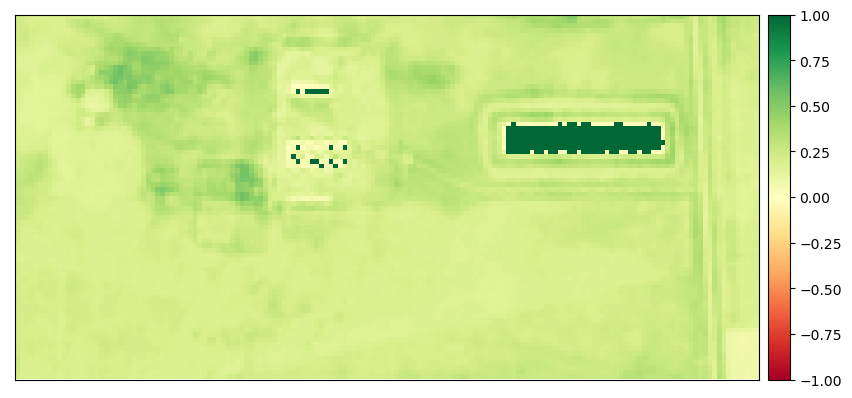

In [65]:
test10_arr = arr10_st[:, y_axis_cut1:y_axis_cut2, x_axis_cut1:x_axis_cut2]

ndvi = es.normalized_diff(test10_arr[3], test10_arr[2])
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

# Вывод изображения-обрезки пастбища 
## (со сдвигом)

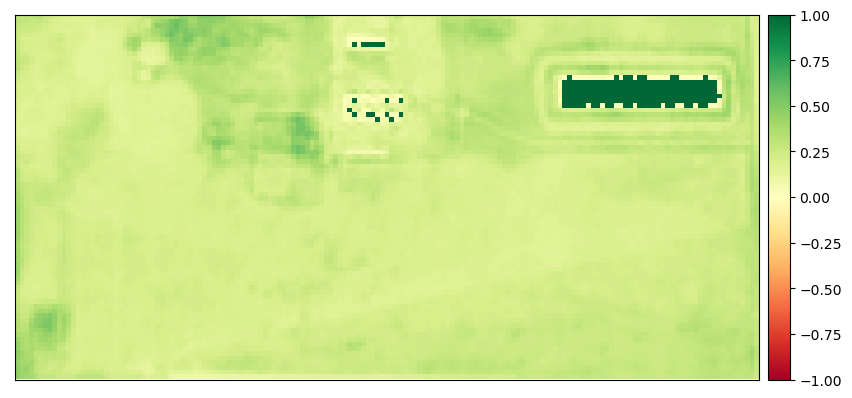

In [66]:
x_dif, y_dif = -12, 10
test10_arr = arr10_st[:, y_axis_cut1+y_dif:y_axis_cut2+y_dif, x_axis_cut1+x_dif:x_axis_cut2+x_dif]

ndvi = es.normalized_diff(test10_arr[3], test10_arr[2])
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

# Маска Загона №1

In [67]:
width, height = test10_arr.shape[2], test10_arr.shape[1]

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\1999567254.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


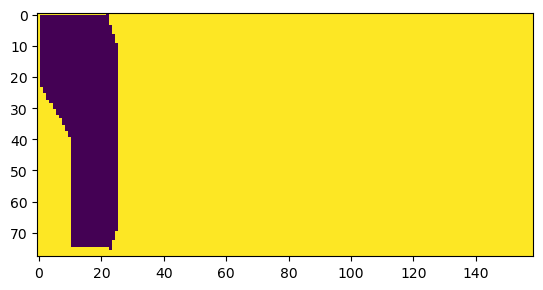

In [68]:
polygon=[]

for coords in pasture_df.loc[0].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask1 = ~poly_path.contains_points(coors)
plt.imshow(mask1.reshape(height, width))
plt.show()

# Маска Загона №2

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\3483175896.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


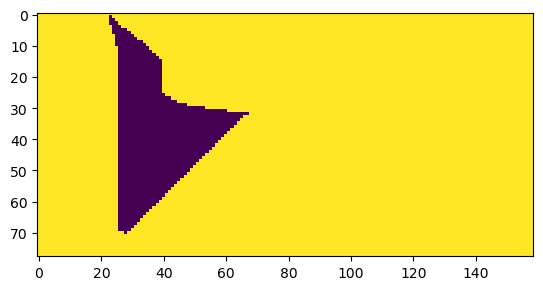

In [69]:
polygon=[]

for coords in pasture_df.loc[1].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask2 = ~poly_path.contains_points(coors)
plt.imshow(mask2.reshape(height, width))
plt.show()

# Маска Загона №3

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2025358053.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


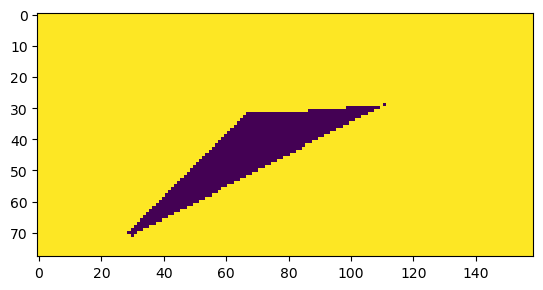

In [70]:
polygon=[]

for coords in pasture_df.loc[2].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask3 = ~poly_path.contains_points(coors)
plt.imshow(mask3.reshape(height, width))
plt.show()

# Маска Загона №4

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2959811222.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


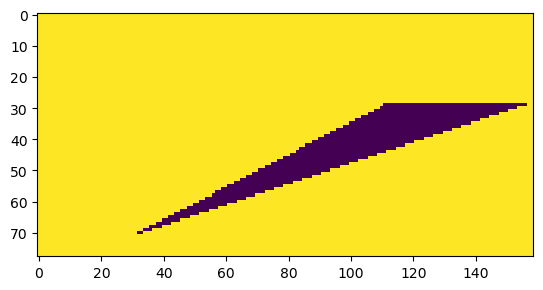

In [71]:
polygon=[]

for coords in pasture_df.loc[3].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask4 = ~poly_path.contains_points(coors)
plt.imshow(mask4.reshape(height, width))
plt.show()

# Маска Загона №5

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2863400869.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


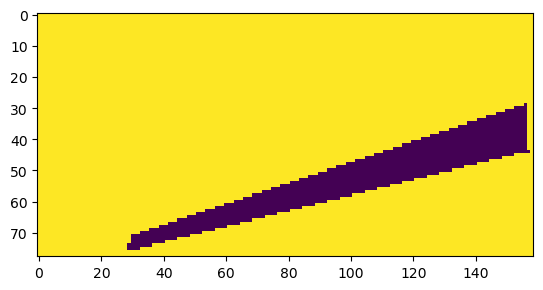

In [72]:
polygon=[]

for coords in pasture_df.loc[4].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask5 = ~poly_path.contains_points(coors)
plt.imshow(mask5.reshape(height, width))
plt.show()

# Маска Загона №6

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\732467880.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


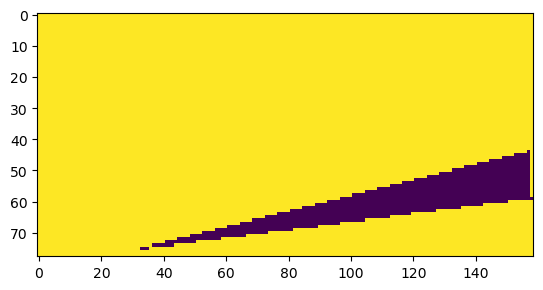

In [73]:
polygon=[]

for coords in pasture_df.loc[5].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask6 = ~poly_path.contains_points(coors)
plt.imshow(mask6.reshape(height, width))
plt.show()

# Маска Загона №7

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_24200\2924174280.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])


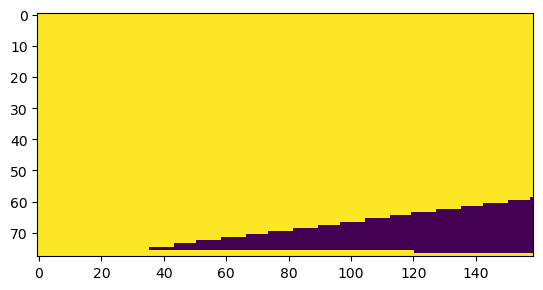

In [74]:
polygon=[]

for coords in pasture_df.loc[6].geometry.exterior.coords:
    
    x, y = pyproj.transform(proj_wgs84, proj_kz, coords[0], coords[1])    
    
    x = int(np.interp(x, [x_min, x_max], [0, width]))
    y = int(np.interp(y, [y_min, y_max], [height, 0]))
    
    polygon.append((y, x))
    
poly_path=Path(polygon)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask7 = ~poly_path.contains_points(coors)
plt.imshow(mask7.reshape(height, width))
plt.show()

In [76]:
mx1 = ma.masked_array(ndvi, mask=mask1.reshape(height, width))
mx2 = ma.masked_array(ndvi, mask=mask2.reshape(height, width))
mx3 = ma.masked_array(ndvi, mask=mask3.reshape(height, width))
mx4 = ma.masked_array(ndvi, mask=mask4.reshape(height, width))
mx5 = ma.masked_array(ndvi, mask=mask5.reshape(height, width))
mx6 = ma.masked_array(ndvi, mask=mask6.reshape(height, width))
mx7 = ma.masked_array(ndvi, mask=mask7.reshape(height, width))

In [77]:
print("Загон №1. Среднее значение NDVI: ", mx1.mean())
print("Загон №2. Среднее значение NDVI: ", mx2.mean())
print("Загон №3. Среднее значение NDVI: ", mx3.mean())
print("Загон №4. Среднее значение NDVI: ", mx4.mean())
print("Загон №5. Среднее значение NDVI: ", mx5.mean())
print("Загон №6. Среднее значение NDVI: ", mx6.mean())
print("Загон №7. Среднее значение NDVI: ", mx7.mean())

Загон №1. Среднее значение NDVI:  0.19850721600984914
Загон №2. Среднее значение NDVI:  0.2085719577793173
Загон №3. Среднее значение NDVI:  0.21000809364487258
Загон №4. Среднее значение NDVI:  0.20299624885910042
Загон №5. Среднее значение NDVI:  0.1914060472681579
Загон №6. Среднее значение NDVI:  0.22441427093801228
Загон №7. Среднее значение NDVI:  0.2622422848030503


In [78]:
print("Загон №1. Медианное значение NDVI: ", ma.median(mx1))
print("Загон №2. Медианное значение NDVI: ", ma.median(mx2))
print("Загон №3. Медианное значение NDVI: ", ma.median(mx3))
print("Загон №4. Медианное значение NDVI: ", ma.median(mx4))
print("Загон №5. Медианное значение NDVI: ", ma.median(mx5))
print("Загон №6. Медианное значение NDVI: ", ma.median(mx6))
print("Загон №7. Медианное значение NDVI: ", ma.median(mx7))

Загон №1. Медианное значение NDVI:  0.19667085271943147
Загон №2. Медианное значение NDVI:  0.20155038759689922
Загон №3. Медианное значение NDVI:  0.20419868355008916
Загон №4. Медианное значение NDVI:  0.19587627362979826
Загон №5. Медианное значение NDVI:  0.18575788402848423
Загон №6. Медианное значение NDVI:  0.21953255425709517
Загон №7. Медианное значение NDVI:  0.2565967172241845


In [79]:
print("Загон №1. Гармоническое среднее значение NDVI: ", hmean(mx1.reshape(width*height)))
print("Загон №2. Гармоническое среднее значение NDVI: ", hmean(mx2.reshape(width*height)))
print("Загон №3. Гармоническое среднее значение NDVI: ", hmean(mx3.reshape(width*height)))
print("Загон №4. Гармоническое среднее значение NDVI: ", hmean(mx4.reshape(width*height)))
print("Загон №5. Гармоническое среднее значение NDVI: ", hmean(mx5.reshape(width*height)))
print("Загон №6. Гармоническое среднее значение NDVI: ", hmean(mx6.reshape(width*height)))
print("Загон №7. Гармоническое среднее значение NDVI: ", hmean(mx7.reshape(width*height)))

Загон №1. Гармоническое среднее значение NDVI:  0.19295638201797974
Загон №2. Гармоническое среднее значение NDVI:  0.20137714146238292
Загон №3. Гармоническое среднее значение NDVI:  0.20759853319317018
Загон №4. Гармоническое среднее значение NDVI:  0.19957006844623804
Загон №5. Гармоническое среднее значение NDVI:  0.1885344348710432
Загон №6. Гармоническое среднее значение NDVI:  0.22245812730845024
Загон №7. Гармоническое среднее значение NDVI:  0.2597172996046254


In [80]:
print("Загон №1. Геометрическое среднее значение NDVI: ", gmean(mx1.reshape(width*height)))
print("Загон №2. Геометрическое среднее значение NDVI: ", gmean(mx2.reshape(width*height)))
print("Загон №3. Геометрическое среднее значение NDVI: ", gmean(mx3.reshape(width*height)))
print("Загон №4. Геометрическое среднее значение NDVI: ", gmean(mx4.reshape(width*height)))
print("Загон №5. Геометрическое среднее значение NDVI: ", gmean(mx5.reshape(width*height)))
print("Загон №6. Геометрическое среднее значение NDVI: ", gmean(mx6.reshape(width*height)))
print("Загон №7. Геометрическое среднее значение NDVI: ", gmean(mx7.reshape(width*height)))

Загон №1. Геометрическое среднее значение NDVI:  0.1956704956656418
Загон №2. Геометрическое среднее значение NDVI:  0.20474411331753364
Загон №3. Геометрическое среднее значение NDVI:  0.20875124151564134
Загон №4. Геометрическое среднее значение NDVI:  0.20122823281658517
Загон №5. Геометрическое среднее значение NDVI:  0.18992516310116273
Загон №6. Геометрическое среднее значение NDVI:  0.22339884924779507
Загон №7. Геометрическое среднее значение NDVI:  0.26096087578874577


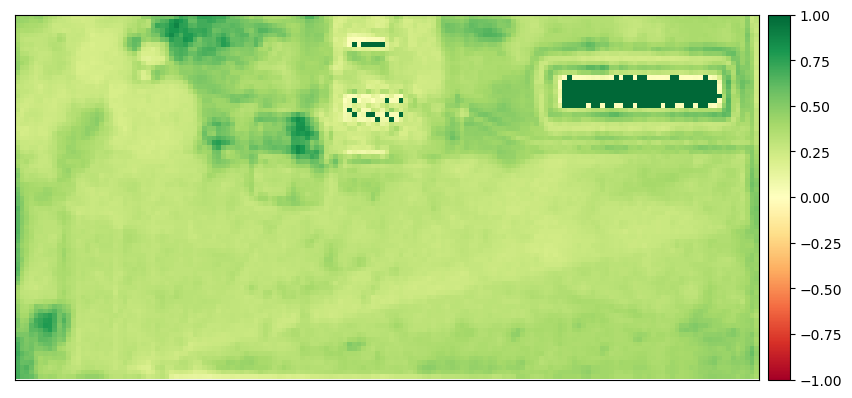

In [81]:
L = 0.5
savi = ((test10_arr[3] - test10_arr[2]) / (test10_arr[3] + test10_arr[2] + L)) * (1 + L)

ep.plot_bands(savi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [82]:
mx1 = ma.masked_array(savi, mask=mask1.reshape(height, width))
mx2 = ma.masked_array(savi, mask=mask2.reshape(height, width))
mx3 = ma.masked_array(savi, mask=mask3.reshape(height, width))
mx4 = ma.masked_array(savi, mask=mask4.reshape(height, width))
mx5 = ma.masked_array(savi, mask=mask5.reshape(height, width))
mx6 = ma.masked_array(savi, mask=mask6.reshape(height, width))
mx7 = ma.masked_array(savi, mask=mask7.reshape(height, width))

In [83]:
print("Загон №1. Среднее значение SAVI: ", mx1.mean())
print("Загон №2. Среднее значение SAVI: ", mx2.mean())
print("Загон №3. Среднее значение SAVI: ", mx3.mean())
print("Загон №4. Среднее значение SAVI: ", mx4.mean())
print("Загон №5. Среднее значение SAVI: ", mx5.mean())
print("Загон №6. Среднее значение SAVI: ", mx6.mean())
print("Загон №7. Среднее значение SAVI: ", mx7.mean())

Загон №1. Среднее значение SAVI:  0.2977302416280728
Загон №2. Среднее значение SAVI:  0.31282771699936973
Загон №3. Среднее значение SAVI:  0.3149818012800842
Загон №4. Среднее значение SAVI:  0.30446304189044876
Загон №5. Среднее значение SAVI:  0.2870795328351535
Загон №6. Среднее значение SAVI:  0.3365861113785989
Загон №7. Среднее значение SAVI:  0.3933217773476606


In [84]:
print("Загон №1. Медианное значение SAVI: ", ma.median(mx1))
print("Загон №2. Медианное значение SAVI: ", ma.median(mx2))
print("Загон №3. Медианное значение SAVI: ", ma.median(mx3))
print("Загон №4. Медианное значение SAVI: ", ma.median(mx4))
print("Загон №5. Медианное значение SAVI: ", ma.median(mx5))
print("Загон №6. Медианное значение SAVI: ", ma.median(mx6))
print("Загон №7. Медианное значение SAVI: ", ma.median(mx7))

Загон №1. Медианное значение SAVI:  0.2949785007725752
Загон №2. Медианное значение SAVI:  0.30229895181890254
Загон №3. Медианное значение SAVI:  0.3062687887554545
Загон №4. Медианное значение SAVI:  0.2937863665906758
Загон №5. Медианное значение SAVI:  0.278608483368935
Загон №6. Медианное значение SAVI:  0.32926447574334894
Загон №7. Медианное значение SAVI:  0.38485509504518545


In [85]:
print("Загон №1. Гармоническое среднее значение SAVI: ", hmean(mx1.reshape(width*height)))
print("Загон №2. Гармоническое среднее значение SAVI: ", hmean(mx2.reshape(width*height)))
print("Загон №3. Гармоническое среднее значение SAVI: ", hmean(mx3.reshape(width*height)))
print("Загон №4. Гармоническое среднее значение SAVI: ", hmean(mx4.reshape(width*height)))
print("Загон №5. Гармоническое среднее значение SAVI: ", hmean(mx5.reshape(width*height)))
print("Загон №6. Гармоническое среднее значение SAVI: ", hmean(mx6.reshape(width*height)))
print("Загон №7. Гармоническое среднее значение SAVI: ", hmean(mx7.reshape(width*height)))

Загон №1. Гармоническое среднее значение SAVI:  0.28940458228493615
Загон №2. Гармоническое среднее значение SAVI:  0.30203632039890504
Загон №3. Гармоническое среднее значение SAVI:  0.31136772394557305
Загон №4. Гармоническое среднее значение SAVI:  0.2993242376897762
Загон №5. Гармоническое среднее значение SAVI:  0.2827725295045772
Загон №6. Гармоническое среднее значение SAVI:  0.3336521532280638
Загон №7. Гармоническое среднее значение SAVI:  0.38953457053488016


In [86]:
print("Загон №1. Геометрическое среднее значение SAVI: ", gmean(mx1.reshape(width*height)))
print("Загон №2. Геометрическое среднее значение SAVI: ", gmean(mx2.reshape(width*height)))
print("Загон №3. Геометрическое среднее значение SAVI: ", gmean(mx3.reshape(width*height)))
print("Загон №4. Геометрическое среднее значение SAVI: ", gmean(mx4.reshape(width*height)))
print("Загон №5. Геометрическое среднее значение SAVI: ", gmean(mx5.reshape(width*height)))
print("Загон №6. Геометрическое среднее значение SAVI: ", gmean(mx6.reshape(width*height)))
print("Загон №7. Геометрическое среднее значение SAVI: ", gmean(mx7.reshape(width*height)))

Загон №1. Геометрическое среднее значение SAVI:  0.29347547534900364
Загон №2. Геометрическое среднее значение SAVI:  0.3070864082145504
Загон №3. Геометрическое среднее значение SAVI:  0.313096662245724
Загон №4. Геометрическое среднее значение SAVI:  0.3018112636680598
Загон №5. Геометрическое среднее значение SAVI:  0.2848584217420491
Загон №6. Геометрическое среднее значение SAVI:  0.335063111244708
Загон №7. Геометрическое среднее значение SAVI:  0.3913997981876828
